# Handwritten Digit Recognition for MNIST (4)
## Using 5 layer neural network 
### Activation function: RELU  
This is an example of evaluating learning rate's effect on 5 layer neural network for Handwritten Digit Recognition. I'm using MNIST dataset to train and test. This model includes 5 layer neural network with ReLU activation function and variable learning rate.

<a href='http://www.mlrocks.com/handwritten-digit-recognizer-using-5-layer-feedforward-neural-network/'>Read more</a>

In [1]:
# importing needed libraries
%matplotlib inline

import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import tensorflow as tf
import math

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [1]:
def plot_batch_images(images, labels, predictions = None, count = 100):
    
    plt.rcParams['axes.linewidth'] = 0.5
    count_row_col = int(np.sqrt(count))
    print(count_row_col)
    fig = plt.figure(figsize=(10, 10))
    
    for i in range(count - int(np.sqrt(count))):
        label = labels[i]
        image = images[i].reshape([28,28])
        sub = plt.subplot(count_row_col, count_row_col, i + 1)
        sub.set_xticks(())
        sub.set_yticks(())
        sub.text(1, 1, label, ha='center', va='top', size=8, color="k")
        
        if not(predictions is None):
            pred = predictions[i]
            sub.text(25, 1, pred, ha='center', va='top', size=8, color="r")
        
        sub.imshow(image, cmap=plt.get_cmap('gray_r'))
    
    fig.tight_layout(pad = 0)
    plt.show()

In [4]:
# parameters
BATCH_SIZE = 100
ITERATION_COUNT = 10000
ACCURACY_CHECK = 100

In [5]:
def train_model(mnist_data):
    
    image_width  = 28
    image_height = 28
    
    C0 = 1   # input channel count
    C1 = 200 # Neuron count for layer 1
    C2 = 100 # Neuron count for layer 2
    C3 = 60  # Neuron count for layer 3
    C4 = 30  # Neuron count for layer 4
    C5 = 10  # Neuron count for layer 5 (digit count 0 to 9)
    
    # weights
    W1 = tf.Variable(tf.truncated_normal([image_width * image_height, C1], stddev = 0.1)) 
    W2 = tf.Variable(tf.truncated_normal([C1, C2], stddev = 0.1))
    W3 = tf.Variable(tf.truncated_normal([C2, C3], stddev = 0.1))
    W4 = tf.Variable(tf.truncated_normal([C3, C4], stddev = 0.1))
    W5 = tf.Variable(tf.truncated_normal([C4, C5], stddev = 0.1))
    
    # biases
    B1 = tf.Variable(tf.zeros([C1]))
    B2 = tf.Variable(tf.zeros([C2]))
    B3 = tf.Variable(tf.zeros([C3]))
    B4 = tf.Variable(tf.zeros([C4]))
    B5 = tf.Variable(tf.zeros([C5]))
    
    # model
    X  = tf.placeholder(tf.float32, shape=[None, image_width * image_height])
    Y1 = tf.nn.relu(tf.matmul(X , W1) + B1)
    Y2 = tf.nn.relu(tf.matmul(Y1, W2) + B2)
    Y3 = tf.nn.relu(tf.matmul(Y2, W3) + B3)
    Y4 = tf.nn.relu(tf.matmul(Y3, W4) + B4)
    Ylogits = tf.matmul(Y4, W5) + B5
    Y = tf.nn.softmax(Ylogits)
    
    # paceholder for learing_rate variable
    lr = tf.placeholder(tf.float32)
    
    # placeholder for correct answers
    Y_ = tf.placeholder(tf.float32, [None, C5])
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
    cross_entropy = tf.reduce_mean(cross_entropy) * 100
    
    # accuracy of the trained model, between 0 (worst) and 1 (best)
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # training step, the learning rate is a placeholder
    train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

    # initialisation
    tf.set_random_seed(0)
    init = tf.global_variables_initializer()

    # start computation
    sess = tf.Session()
    sess.run(init)
    
    # preparing return values
    counter = 0 
    upper_bound = int(ITERATION_COUNT / ACCURACY_CHECK)
    iterations = np.arange(0, upper_bound)
    train_accuracy = np.zeros(upper_bound)
    train_loss = np.zeros(upper_bound)
    test_accuracy = np.zeros(upper_bound)
    test_loss = np.zeros(upper_bound)
    learning_rates = np.zeros(1)
    
    for i in range(ITERATION_COUNT):
        
        # learning rate decay
        max_learning_rate = 0.003
        min_learning_rate = 0.0001
        decay_speed = 2000.0 # 0.003-0.0001-2000=>0.9826 done in 5000 iterations
        learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)
        
        # load batch of images and correct answers
        batch_X , batch_Y = mnist_data.train.next_batch(BATCH_SIZE)
        train_data = {X: batch_X, Y_: batch_Y, lr: learning_rate}
        
        # train
        sess.run(train_step, feed_dict = train_data)
        
        if i % ACCURACY_CHECK == 0:
            
            a , c = sess.run([accuracy, cross_entropy], feed_dict = train_data)
            train_accuracy[counter] = a
            train_loss[counter] = c
            
            test_data = {X: mnist_data.test.images, Y_: mnist_data.test.labels}
            pred, a , c = sess.run([Y, accuracy, cross_entropy], feed_dict = test_data)
            predictions = tf.argmax(pred,1).eval(session=sess)
           
            test_accuracy[counter] = a
            test_loss[counter] = c
            counter += 1
            
            #print('{} - Learning Rate: {}, Accuracy: {}'.format(i, learning_rate, a))
                        
    learning_rates[0] = learning_rate
    acc = accuracy.eval(session = sess, feed_dict = {X: mnist_data.test.images, Y_: mnist_data.test.labels})
    print('Learning Rate: {}, Accuracy: {}'.format(learning_rate, acc))
    sess.close()
    
    return train_accuracy, train_loss, test_accuracy, test_loss, predictions, learning_rates;

In [6]:
train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []
predictions = []
learning_rates = []

%time ta, tl, tsa, tsl, preds, lr = train_model(mnist)
train_accuracy.append(ta)
train_loss.append(tl)
test_accuracy.append(tsa)
test_loss.append(tsl)
predictions.append(preds)
learning_rates.append(lr)
    
acc_check = np.arange(0, len(train_accuracy[0]))

Learning Rate: 0.00011954981876340945, Accuracy: 0.9809001684188843
Wall time: 39.5 s


In [7]:
def plot_performance_chart(X, Ys, legend_labels, label, loc = 'lower right', xmin = None, xmax = None, ymin = None, ymax = None):
    
    COLORS = ['r', 'g', 'b', 'm', 'c', 'y']
    
    if not(Ys is None):
        
        plt.figure(figsize=(10,4))
        
        for i in range(len(legend_labels)):
            plt.plot(X, Ys[i], c = COLORS[i], label = legend_labels[i])
            plt.legend(loc = loc, frameon = True, prop = {'size':7}, title = "Learning Rate")
            
            if not(xmin is None):
                plt.xlim(xmin = xmin, xmax = xmax)
                
            if not(ymin is None):
                plt.ylim(ymin = ymin, ymax = ymax)

        plt.ylabel(label)
        plt.xlabel('Steps')
        plt.show()

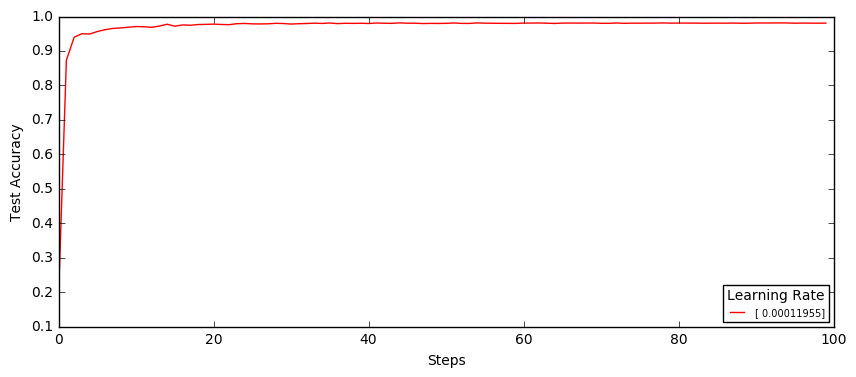

In [8]:
plot_performance_chart(acc_check, test_accuracy, learning_rates, 'Test Accuracy')

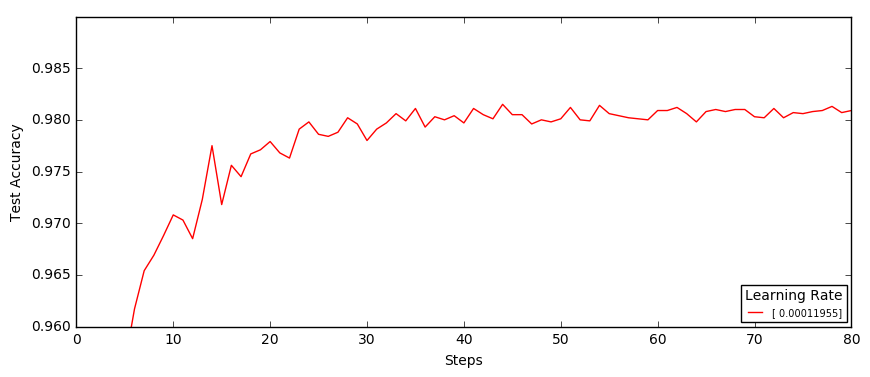

In [9]:
plot_performance_chart(acc_check, test_accuracy, learning_rates, 'Test Accuracy', 
                       xmin = 0, xmax = 80, ymin = 0.96, ymax = 0.99)

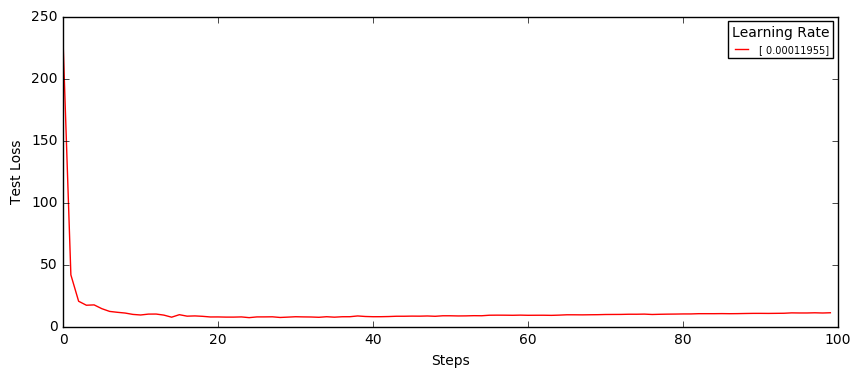

In [10]:
plot_performance_chart(acc_check, test_loss, learning_rates, 'Test Loss', loc = 'upper right')

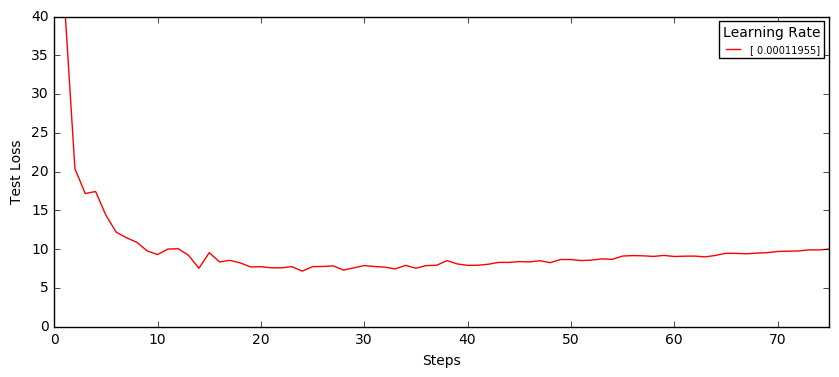

In [11]:
plot_performance_chart(acc_check, test_loss, learning_rates, 'Test Loss', loc = 'upper right',
                       xmin = 0, xmax = 75, ymin = 0, ymax = 40)

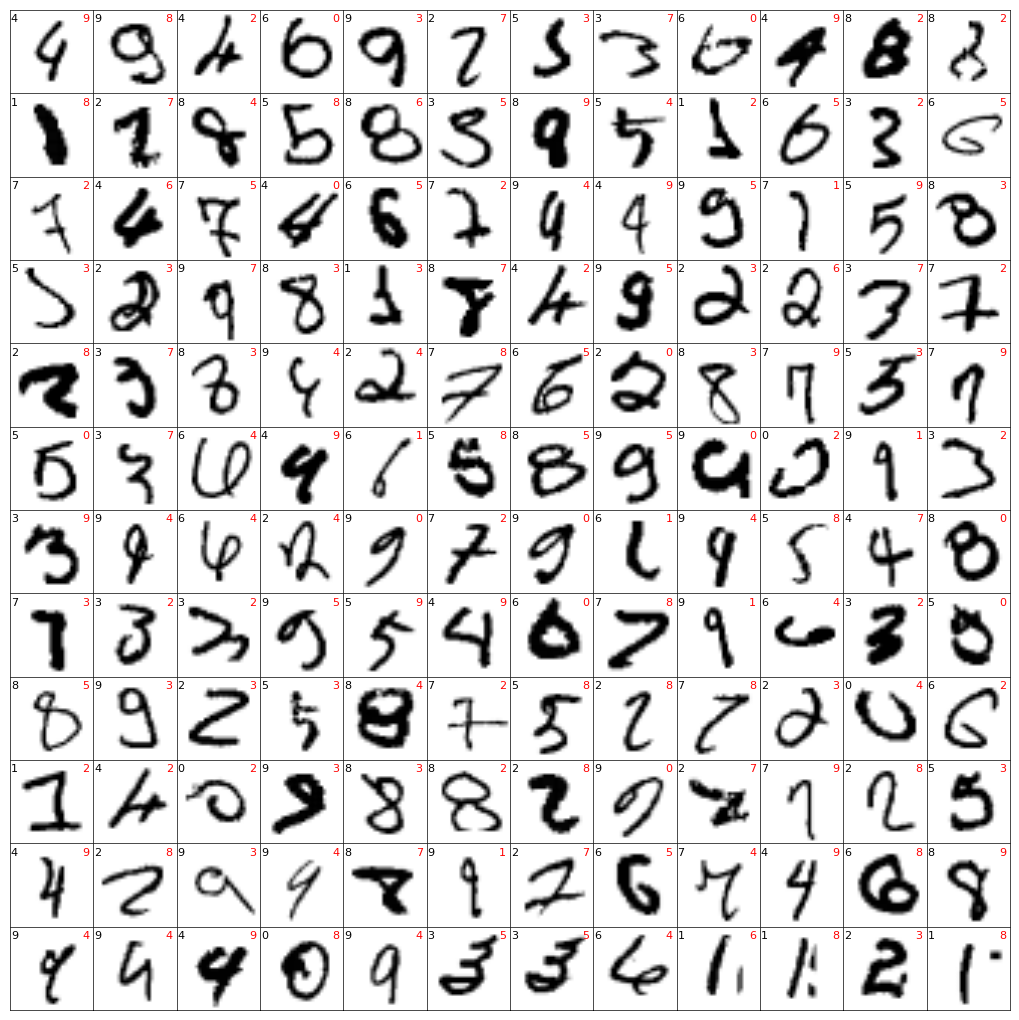

In [12]:
images = mnist.test.images
labels = np.argmax(mnist.test.labels, 1)
lr_index_to_render = 0
preds = predictions[lr_index_to_render]
incorrects = np.not_equal(labels, preds)
plot_batch_images(images[incorrects], labels[incorrects], preds[incorrects], 144)

In [13]:
print('Total number of incorrect predictions is: {}'.format(len(incorrects[incorrects == True])))
print('The best accuracy: {}'.format(test_accuracy[lr_index_to_render][-5:]))

Total number of incorrect predictions is: 193
The best accuracy: [ 0.9805001   0.98100019  0.98070014  0.98060006  0.98070008]
